In [131]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import statsmodels.api as sm
import geopandas as gpd
import datetime

from visual import setting

setting.set_rc_params()

{'axes.linewidth': 1.5,
 'axes.unicode_minus': False,
 'figure.dpi': 300,
 'font.size': 20,
 'legend.frameon': True,
 'legend.handletextpad': 0.4,
 'legend.handlelength': 1,
 'legend.facecolor': 'white',
 'legend.fancybox': True,
 'legend.fontsize': 12,
 'mathtext.default': 'regular',
 'savefig.bbox': 'tight',
 'xtick.labelsize': 12,
 'ytick.labelsize': 12,
 'xtick.major.size': 6,
 'ytick.major.size': 6,
 'xtick.major.width': 1,
 'ytick.major.width': 1,
 'xtick.top': True,
 'ytick.right': True,
 'axes.edgecolor': 'black',
 'savefig.facecolor': 'white',
 'axes.facecolor': 'whitesmoke',
 'font.family': 'sans',
 'font.monospace': 'computer modern roman',
 'text.usetex': True,
 'axes.grid': True,
 'grid.color': 'gray',
 'grid.linestyle': '-',
 'grid.linewidth': 0.2,
 'grid.alpha': 0.3,
 'axes.axisbelow': 'line'}

First we'll get the UCDP Data, you can use the API to get it.

It takes a minimal amount of adjusting to get battledeaths oriented data. One important thing to do is to remove duplicate conflict years which are catloged for different aspects of the conflict in a given year.

In [2]:
# Endpoints
page0 = 'https://ucdpapi.pcr.uu.se/api/battledeaths/22.1?pagesize=1000&page=0'
page1 = 'https://ucdpapi.pcr.uu.se/api/battledeaths/22.1?pagesize=1000&page=1'

data_pages = []
for i in [page0, page1]:
  response = requests.get(i)
  data_pages.append(pd.DataFrame(response.json()['Result']))

conflict_data = pd.concat(data_pages)
conflict_data.columns

bd_deaths = conflict_data.drop_duplicates(subset=['conflict_id', 'year'])
bd_deaths.bd_best = bd_deaths.bd_best.astype(int)
bd_deaths.year = bd_deaths.year.astype(int)

bd_deaths['deaths'] = bd_deaths.bd_best
bd_deaths['country'] = bd_deaths['side_a']


/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
bd_deaths[['deaths', 'year']].describe().round(2)

,deaths,year
count,1403.00,1403.00
mean,999.49,2005.43
std,4229.15,10.14
min,25.00,1989.00
25%,44.00,1996.00
50%,131.00,2006.00
75%,505.00,2015.00
max,70506.00,2021.00


In [43]:
len(bd_deaths['country'].unique())

88

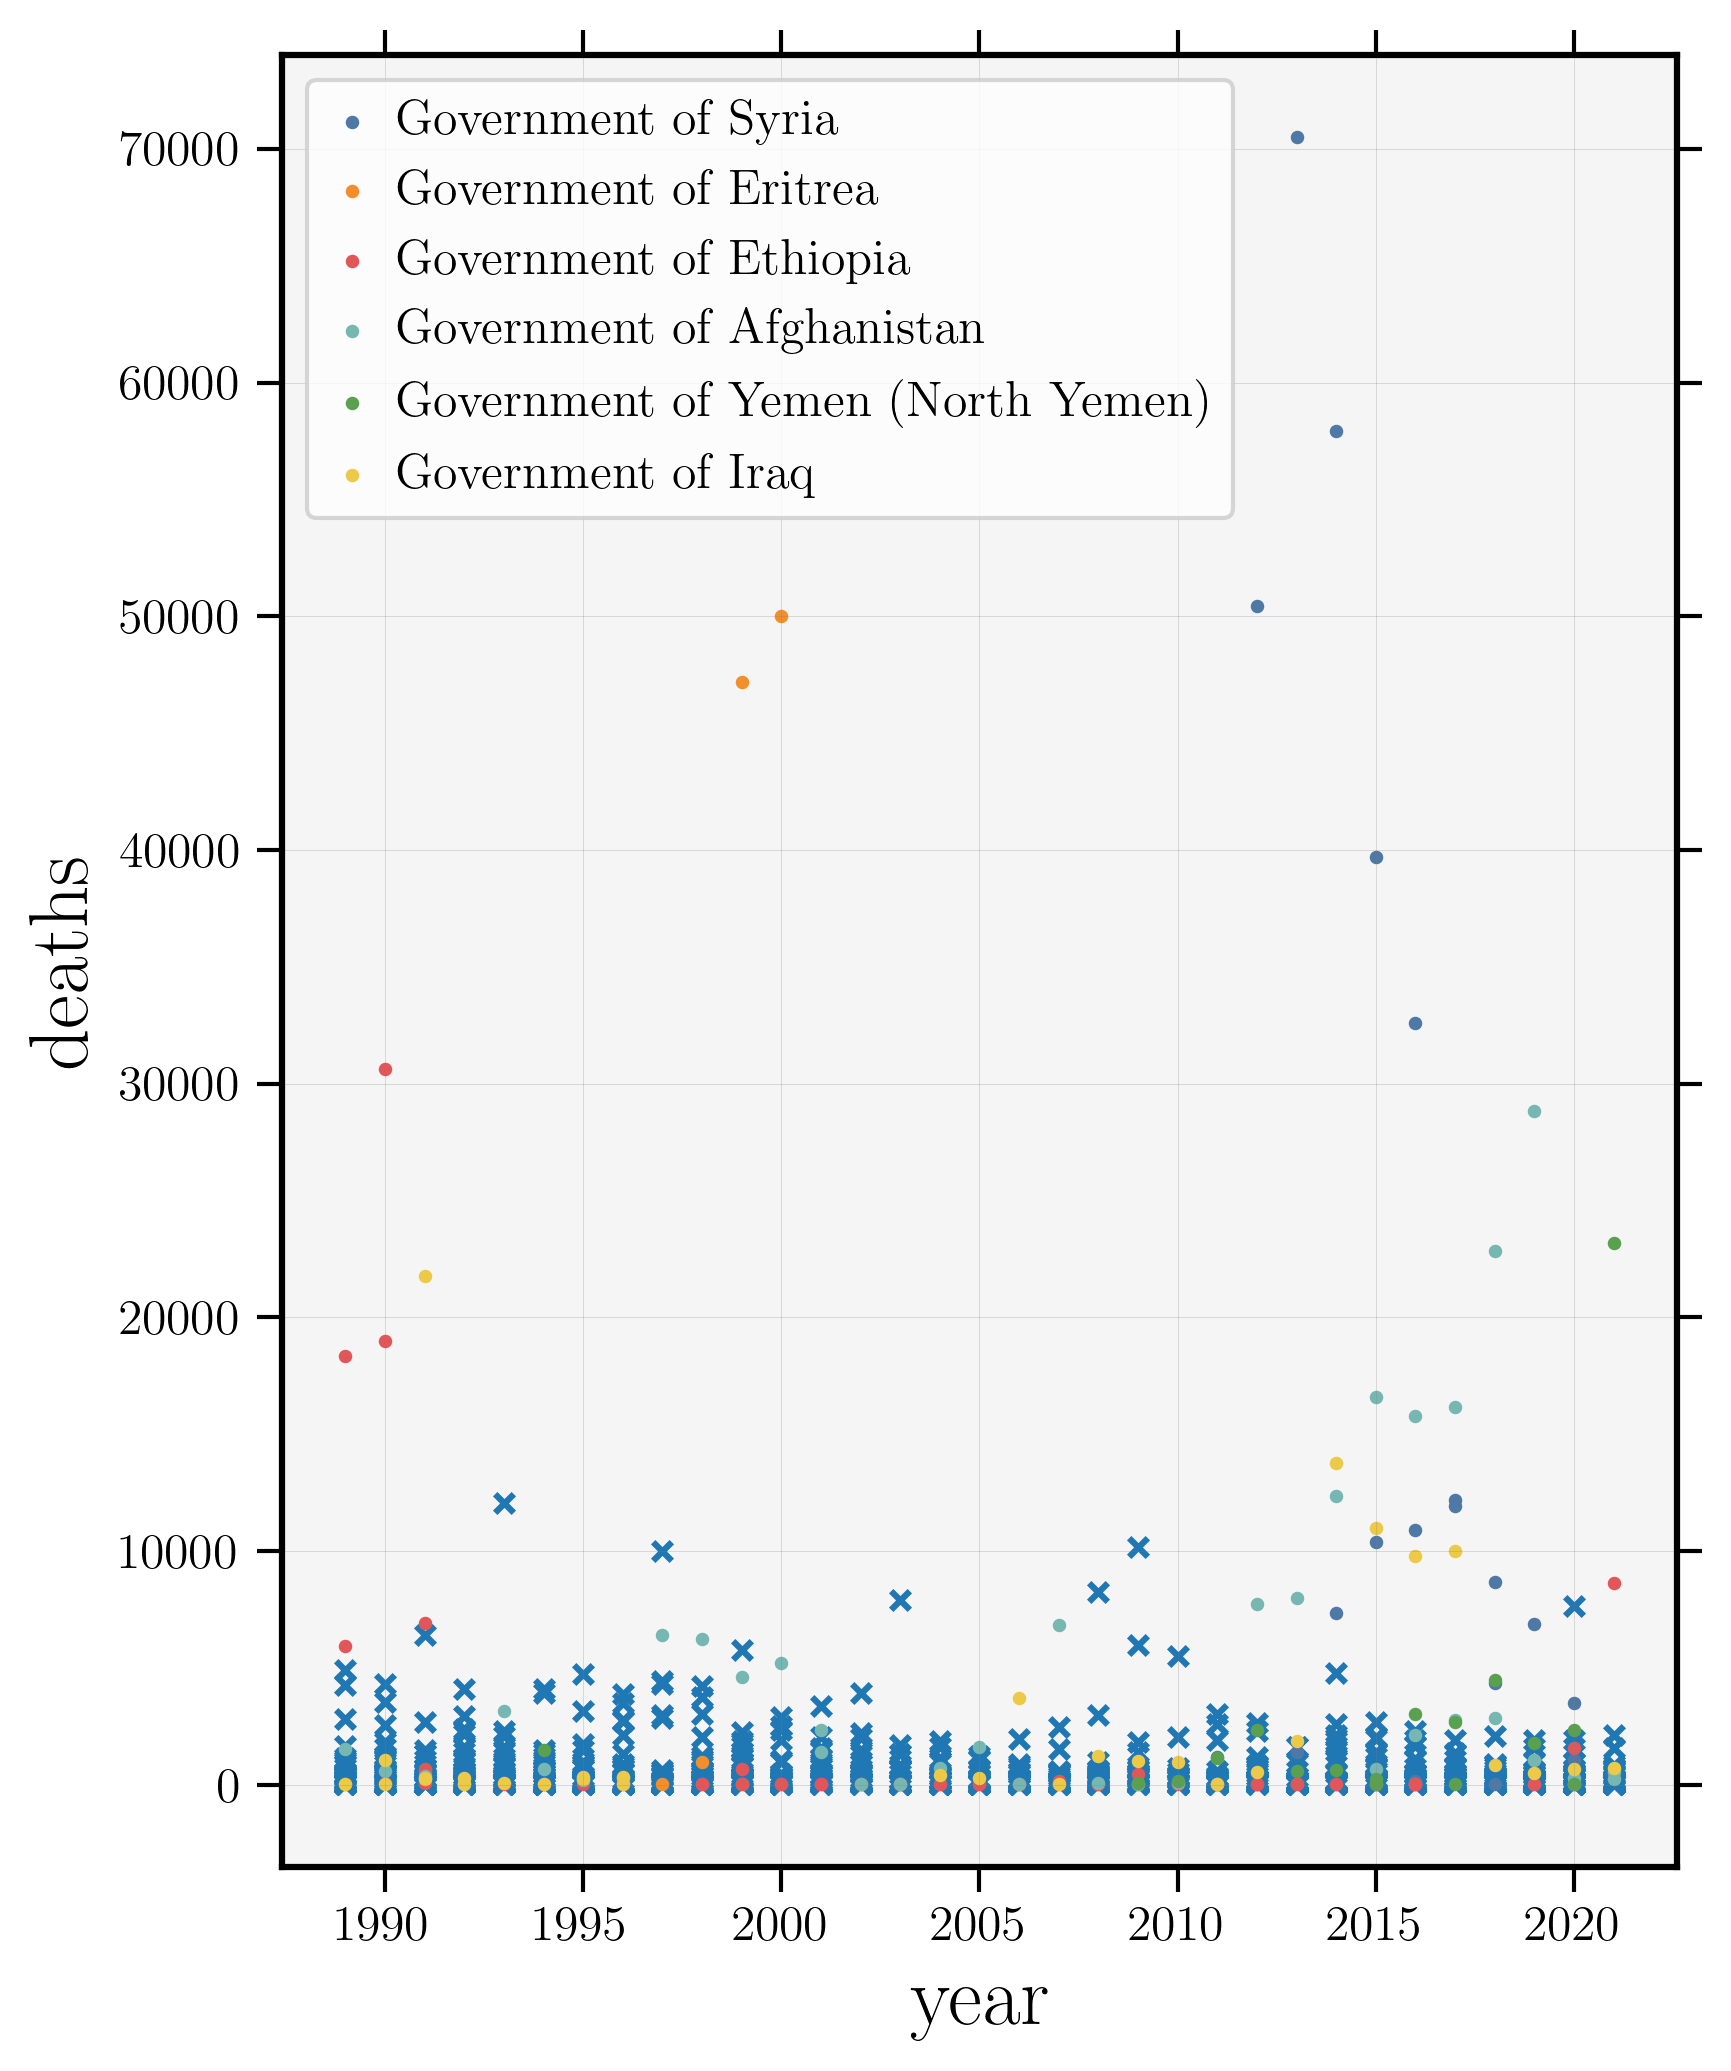

In [36]:
fig, ax = plt.subplots(figsize=(6, 8))

bd_deaths.loc[~bd_deaths['country'].isin(list(bd_deaths.nlargest(15, 'deaths')['country'].unique()))].plot(kind='scatter', x='year', y='deaths', marker='x', ax=ax)
              
for i in zip(list(bd_deaths.nlargest(15, 'deaths')['country'].unique()), ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", "#EDC948"]):
    bd_deaths[bd_deaths['country'] == i[0]].plot(kind='scatter', x='year', y='deaths',color =i[1], ax=ax,marker='.', label=i[0])
plt.savefig('figures/ConflictIntensity.png')


In [38]:
%%capture

sns.jointplot(x='year', y='deaths', data=bd_deaths.loc[bd_deaths.deaths < 100])
plt.savefig('figures/lowIntensityConflictDistribution.png')

In [68]:
bd_deaths.groupby(['conflict_id', 'side_a'])['bd_best'].sum().nlargest(20)

conflict_id  side_a                             
299          Government of Syria                    284317
333          Government of Afghanistan              170193
409          Government of Eritrea                   98217
352          Government of Sri Lanka                 60674
259          Government of Iraq                      58483
13604        Government of Syria                     48589
267          Government of Ethiopia                  48180
275          Government of Ethiopia                  43470
230          Government of Yemen (North Yemen)       42452
309          Government of Sudan                     36391
354          Government of Turkey                    32952
327          Government of Angola                    30227
337          Government of Somalia                   29505
404          Government of Pakistan                  28134
371          Government of Iraq                      22848
364          Government of India                     18988
401    

# Commercial Military Actors Dataset

In [50]:
cmad = pd.read_excel('data/cma_data/Petersohn_et.al_CMA_Dataset_Version2.xlsx')
cmad['year'] = cmad['YEAR']

cmad['ContractCount'] = 1
cyear = cmad.loc[cmad.Serv <=10].groupby(['year', 'COWCCode', 'COWState'])['ContractCount'].sum().reset_index()
cyear['CompanyPresence'] = 1

/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [51]:
cmad.describe()

,COWCCode,YEAR,Region,CMA,Clnt,SpCl,ForT,CoOrR,OpOrR,Serv,AgSt,OwSt,SizeBest,SizeMin,SizeMax,Rly,year
count,7093.000000,7093.000000,7093.000000,7093.000000,7093.000000,7093.000000,7093.000000,7093.00000,7092.000000,7088.000000,7093.000000,7093.000000,724.000000,821.000000,816.000000,7093.000000,7093.000000
mean,498.081771,2005.513182,3.832934,1.000846,216.975892,569.869731,215.490907,137.08304,701.954315,119.160130,8.463979,165.869026,604.096685,896.013398,1109.528186,1.492316,2005.513182
std,213.964948,7.621030,1.253367,0.029074,407.418725,493.175686,410.757015,339.31478,455.244851,315.403506,76.457207,370.239303,2440.621906,3104.629675,3878.459099,0.814494,7.621030
min,41.000000,1980.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1980.000000
25%,451.000000,2002.000000,3.000000,1.000000,4.000000,2.000000,0.000000,2.00000,7.000000,5.000000,2.000000,1.000000,6.750000,9.000000,10.000000,1.000000,2002.000000
50%,540.000000,2007.000000,4.000000,1.000000,5.000000,998.000000,0.000000,4.00000,999.000000,7.000000,3.000000,1.000000,50.000000,58.000000,94.500000,1.000000,2007.000000
75%,645.000000,2011.000000,4.000000,1.000000,9.000000,999.000000,1.000000,5.00000,999.000000,7.000000,3.000000,2.000000,400.000000,365.000000,500.000000,2.000000,2011.000000
max,910.000000,2016.000000,6.000000,2.000000,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,30000.000000,30000.000000,53200.000000,3.000000,2016.000000


In [53]:
cyear[['year', 'ContractCount', 'CompanyPresence']].describe()

,year,ContractCount,CompanyPresence
count,1187.000000,1187.000000,1187.0
mean,2002.898062,5.189553,1.0
std,9.315017,11.453342,0.0
min,1980.000000,1.000000,1.0
25%,1996.000000,1.000000,1.0
50%,2004.000000,2.000000,1.0
75%,2011.000000,5.000000,1.0
max,2016.000000,163.000000,1.0


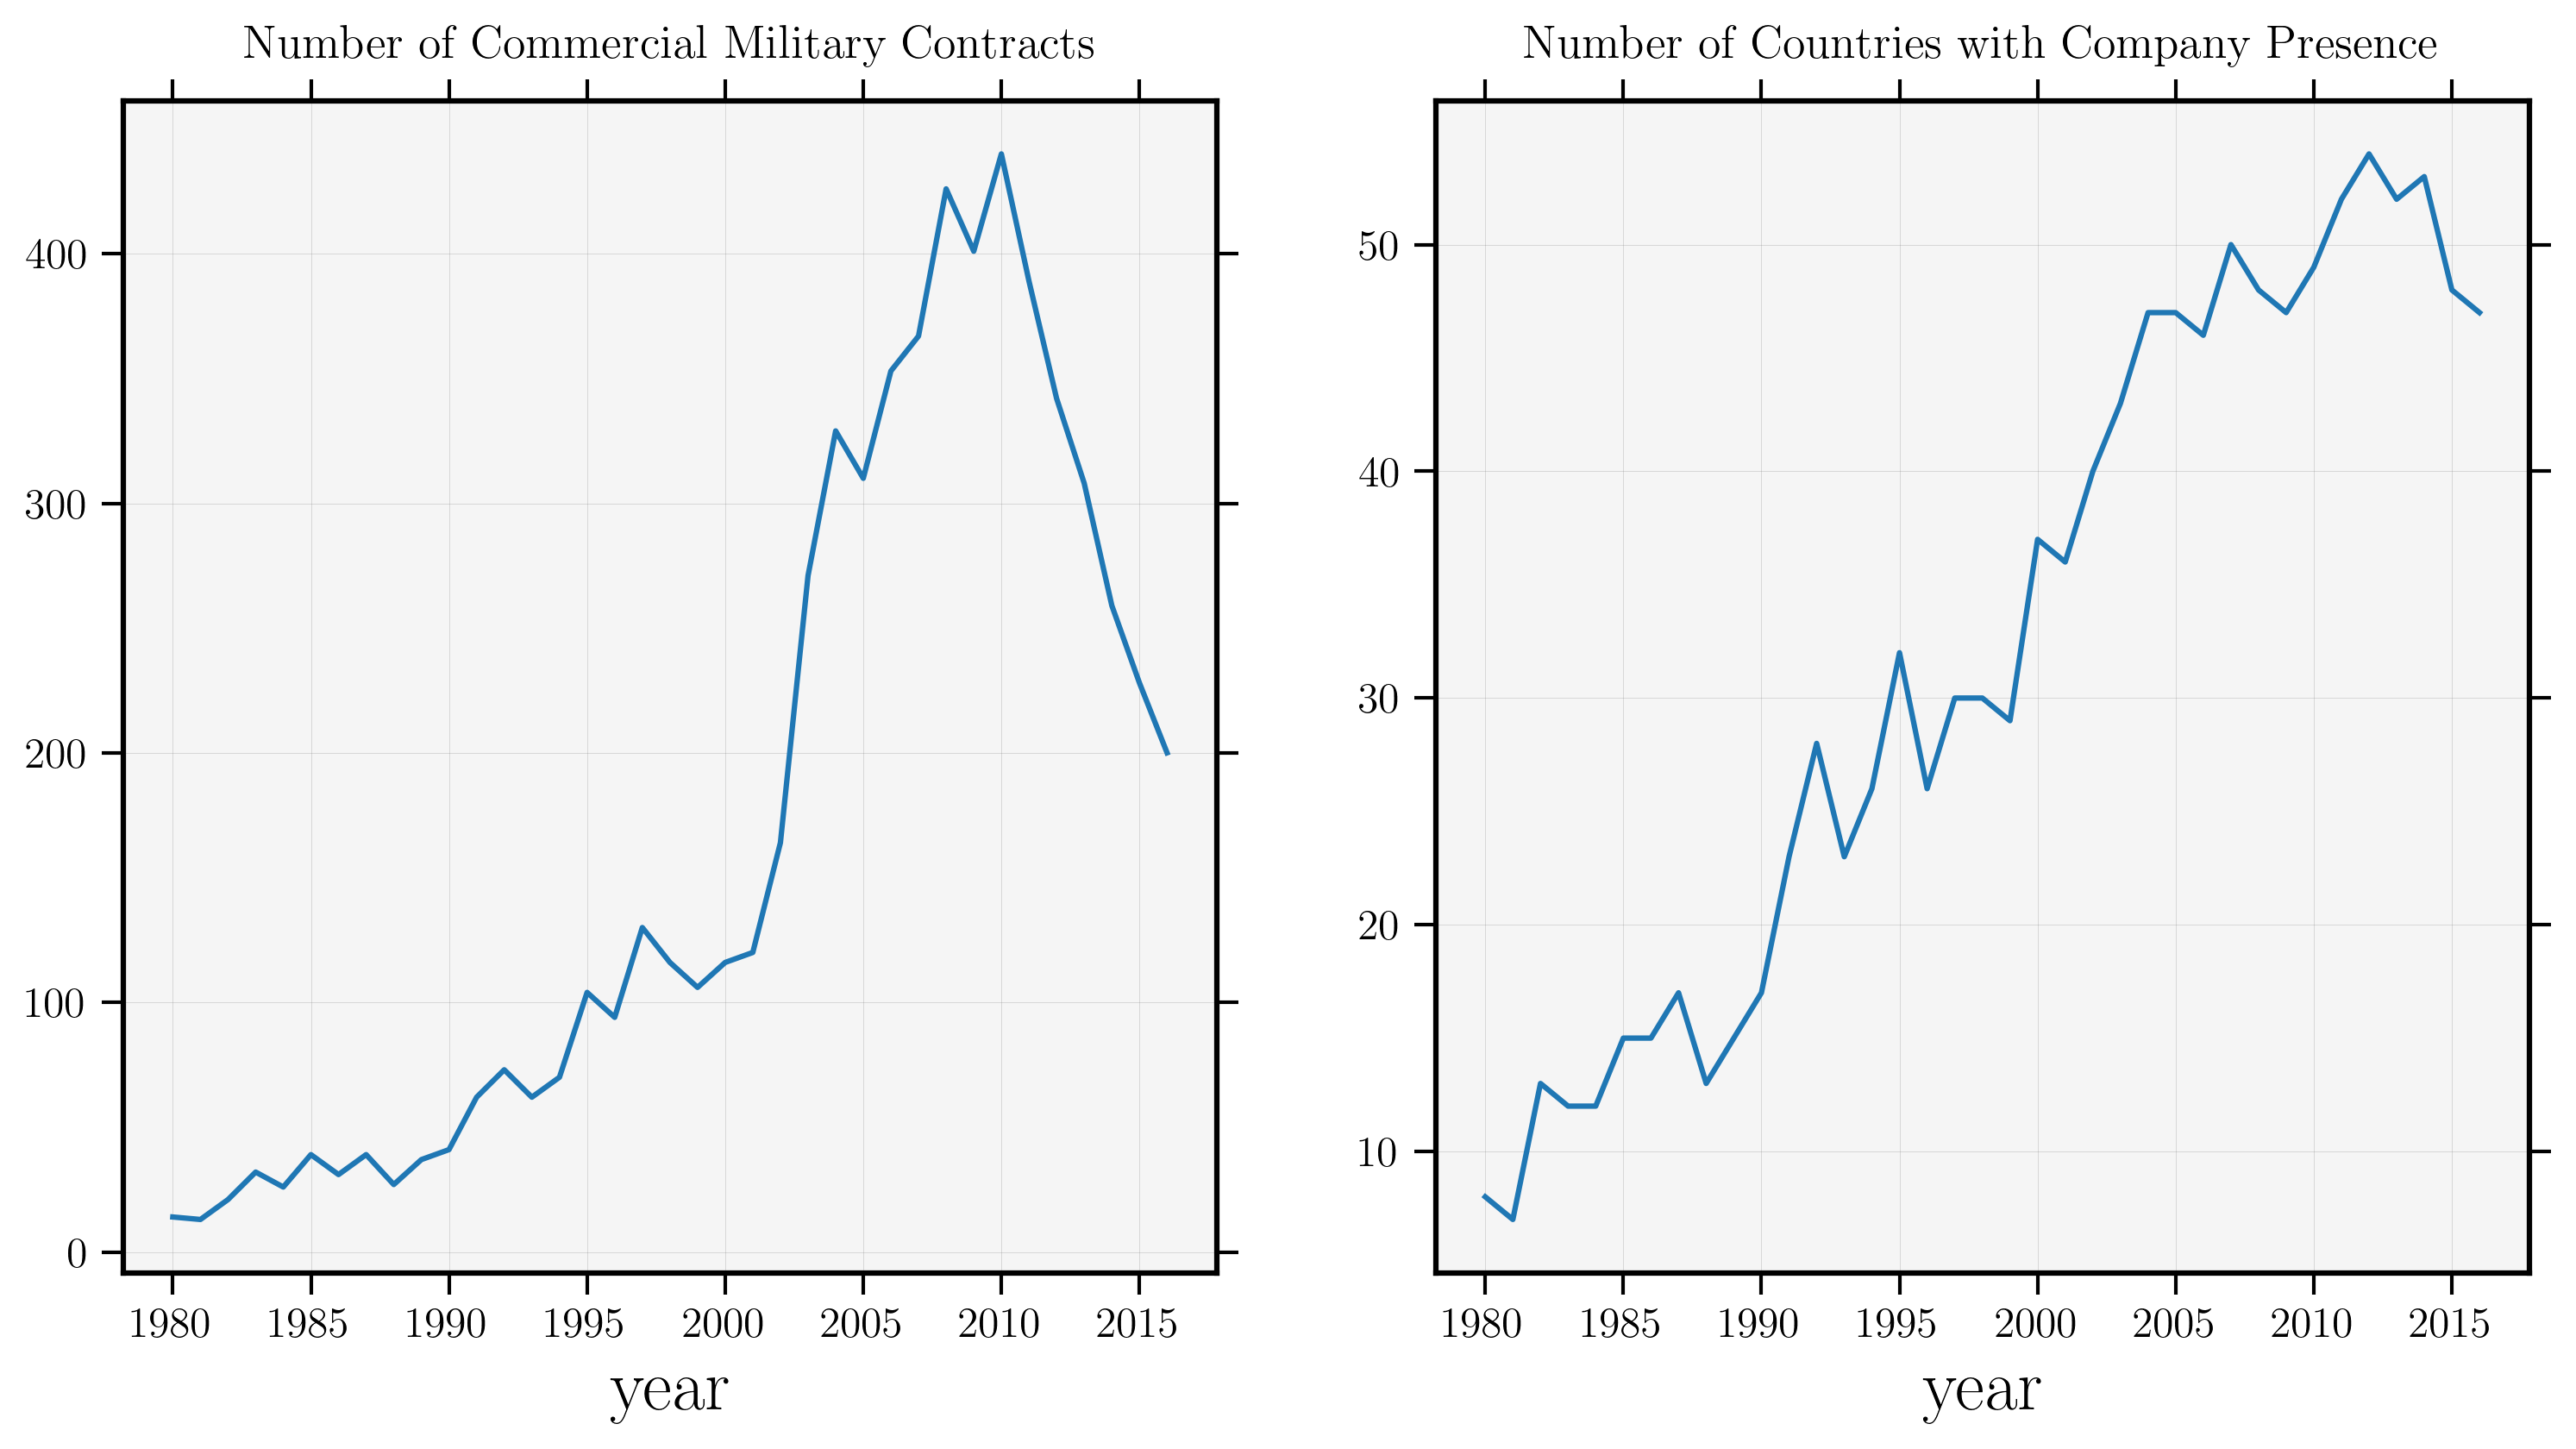

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cyear.groupby('year')['ContractCount'].sum().plot(ax=ax1)
ax1.set_title('Number of Commercial Military Contracts', fontsize=13, pad=12)

cyear.groupby('year')['CompanyPresence'].sum().plot(ax=ax2)
ax2.set_title('Number of Countries with Company Presence', fontsize=13, pad=12)

plt.savefig('figures/CommercialMilitaryContracts.png')

In [69]:
cyear.groupby(['COWCCode', 'COWState'])[['CompanyPresence', 'ContractCount']].sum().nlargest(columns='ContractCount', n=10)

,,CompanyPresence,ContractCount
COWCCode,COWState,,
645,IRQ,19,925
700,AFG,22,767
100,COL,32,432
490,DRC,33,378
540,ANG,34,361
475,NIG,26,282
560,SAF,31,264
520,SOM,23,234
770,PAK,19,144


In [70]:
cyear.groupby(['COWCCode', 'COWState'])[['CompanyPresence', 'ContractCount']].sum().nlargest(columns='CompanyPresence', n=10)

,,CompanyPresence,ContractCount
COWCCode,COWState,,
70,MEX,37,143
651,EGY,37,76
820,MAL,37,57
540,ANG,34,361
490,DRC,33,378
100,COL,32,432
560,SAF,31,264
135,PER,30,96
775,MYA,27,56


In [71]:
cyear['year'] = cyear['year'].astype(int)
bd_deaths['year'] = bd_deaths['year'].astype(int)

cyear['COWCCode'] = cyear['COWCCode'].astype(int)
bd_deaths.gwno_a = bd_deaths.gwno_a.str.replace('900, 200, 2', '900')
bd_deaths['gwno_a'] = bd_deaths['gwno_a'].astype(int)

bd_deaths_limited = bd_deaths.loc[bd_deaths.year <= 2016]
cmad_merged = bd_deaths_limited.merge(cyear, left_on=['gwno_a', 'year'], right_on=['COWCCode', 'year'], how='left')

cmad_merged['CompanyPresence'] = cmad_merged['CompanyPresence'].fillna(0)
cmad_merged['ContractCount'] = cmad_merged['ContractCount'].fillna(0)

/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [72]:
cmad_merged.groupby(['conflict_id', 'side_a'])[['bd_best', 'CompanyPresence', 'ContractCount']].sum().nlargest(20, 'bd_best')

,,bd_best,CompanyPresence,ContractCount
conflict_id,side_a,,,
299,Government of Syria,252372,6.0,22.0
333,Government of Afghanistan,101766,21.0,766.0
409,Government of Eritrea,98217,0.0,0.0
352,Government of Sri Lanka,60674,6.0,7.0
259,Government of Iraq,45716,14.0,829.0
275,Government of Ethiopia,43470,0.0,0.0
267,Government of Ethiopia,37951,0.0,0.0
309,Government of Sudan,36007,16.0,33.0
327,Government of Angola,30227,10.0,142.0


In [73]:
cmad_merged.groupby(['conflict_id', 'side_a'])[['bd_best', 'CompanyPresence', 'ContractCount']].sum().nsmallest(50, 'bd_best')

,,bd_best,CompanyPresence,ContractCount
conflict_id,side_a,,,
363,Government of Ethiopia,25,0.0,0.0
434,Government of India,25,1.0,10.0
13721,Government of Algeria,26,1.0,2.0
15283,Government of Central African Republic,27,0.0,0.0
294,Government of Cambodia (Kampuchea),29,0.0,0.0
362,Government of Comoros,29,1.0,4.0
442,Government of Mauritania,29,0.0,0.0
13886,Government of Jordan,34,1.0,2.0
406,Government of Niger,34,0.0,0.0


In [83]:
corr, pval = pearsonr(cmad_merged['bd_best'], cmad_merged['CompanyPresence'])

print("The correlation statistic between Deaths and Company presence is: ", corr)
print("And the p-value is: ", pval)


The correlation statistic between Deaths and Company presence is:  0.025497002125058565
And the p-value is:  0.3910018338488751


In [84]:
corr, pval = pearsonr(cmad_merged['bd_best'], cmad_merged['ContractCount'])

print("The correlation statistic between Deaths and Contract count is: ",corr)
print("And the p-value is: ", pval)

The correlation statistic between Deaths and Contract count is:  0.04565038838201015
And the p-value is:  0.12444554867040158


In [82]:
group1 = cmad_merged[cmad_merged['CompanyPresence'] == 0]['bd_best']
group2 = cmad_merged[cmad_merged['CompanyPresence'] == 1]['bd_best']

# Perform a t-test between the two groups
tstat, pval = ttest_ind(group1, group2)
print("The t-statistic is %.3f and the p-value is %.3f." % (tstat, pval))

The t-statistic is -0.858 and the p-value is 0.391.


In [108]:
cmad_merged['ContractCountLog'] = np.log(cmad_merged['ContractCount']+0.1)
low_intensity = cmad_merged.loc[cmad_merged.bd_best <= 1000]

In [109]:
corr, pval = pearsonr(low_intensity['bd_best'], low_intensity['CompanyPresence'])

print("The correlation statistic between Deaths and Company presence is: ", corr)
print("And the p-value is: ", pval)

The correlation statistic between Deaths and Company presence is:  0.0321424783125634
And the p-value is:  0.3218354994873532


In [110]:
corr, pval = pearsonr(low_intensity['bd_best'], low_intensity['ContractCountLog'])

print("The correlation statistic between Deaths and Company presence is: ", corr)
print("And the p-value is: ", pval)

The correlation statistic between Deaths and Company presence is:  0.0636237487735073
And the p-value is:  0.04970567263489265


In [114]:
95/len(cmad_merged)

0.0837742504409171

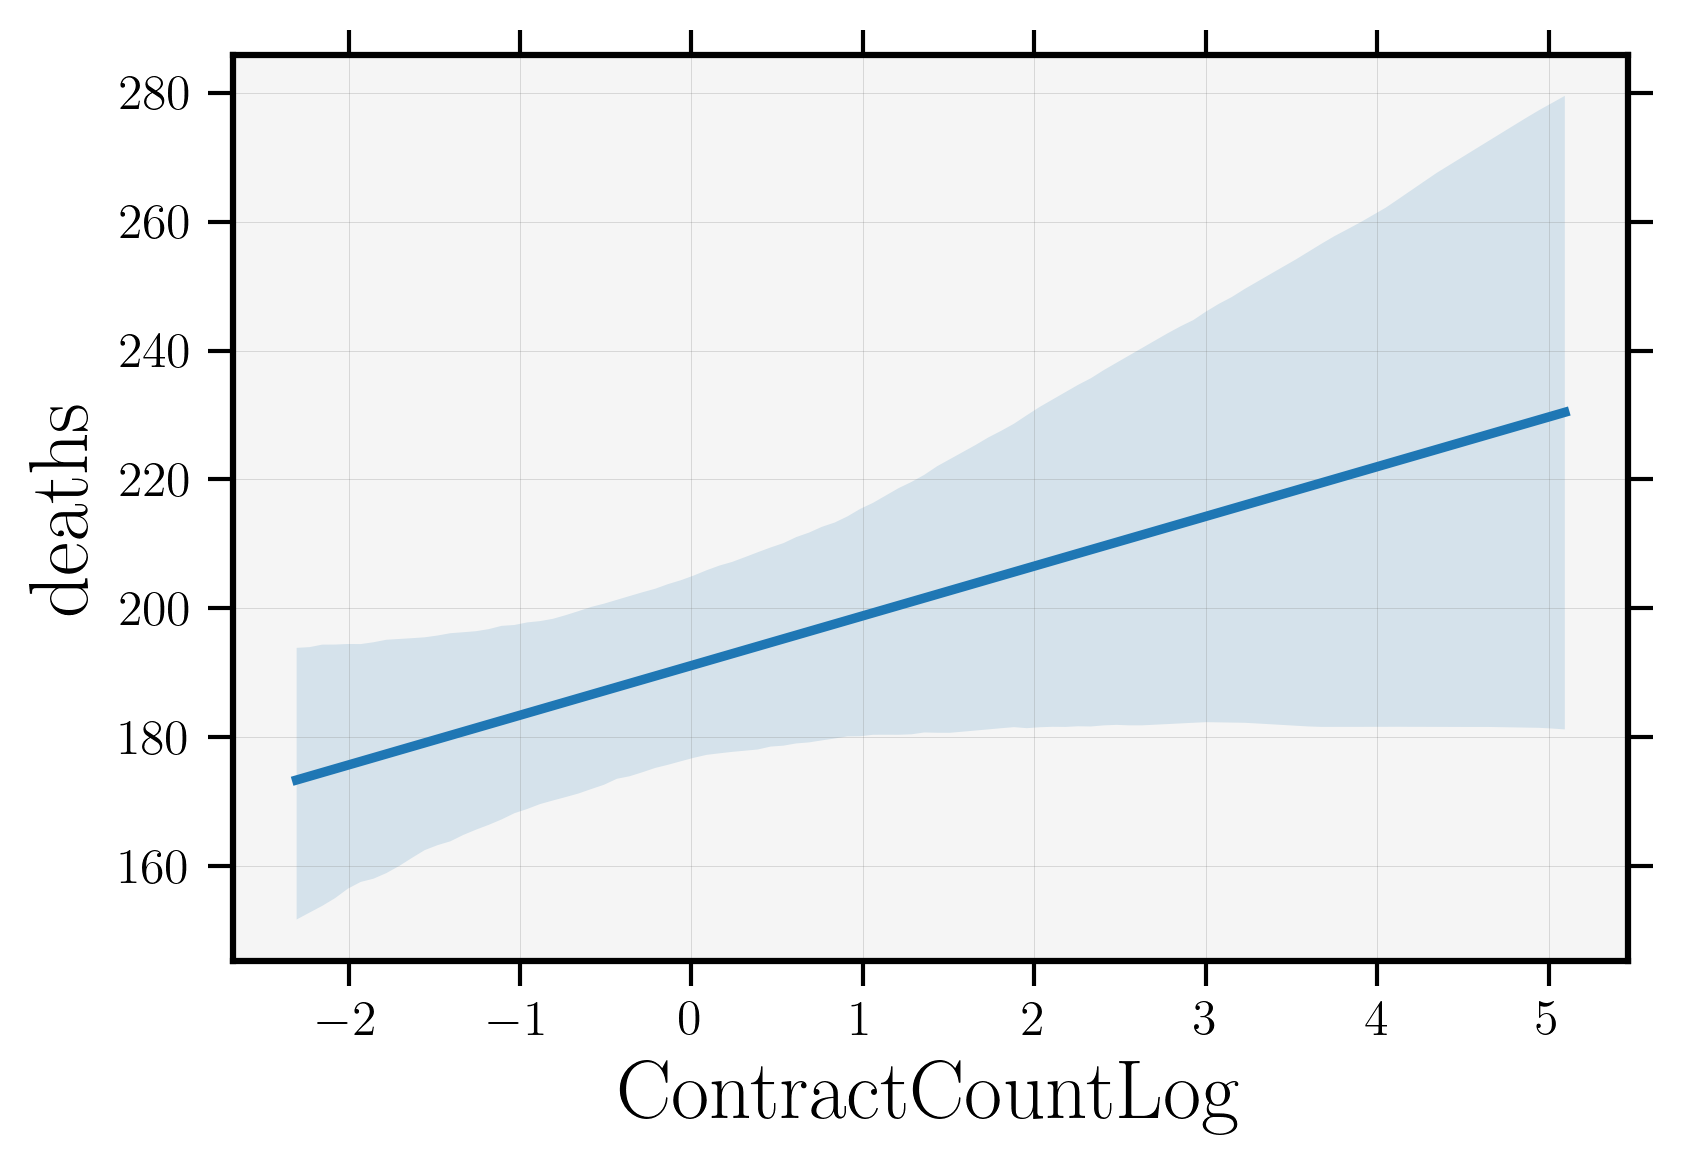

In [118]:

sns.regplot(x='ContractCountLog', y='deaths', data=low_intensity, scatter=False)
plt.savefig('figures/lowIntensityConflictRegression.png')

<AxesSubplot:xlabel='year', ylabel='deaths'>

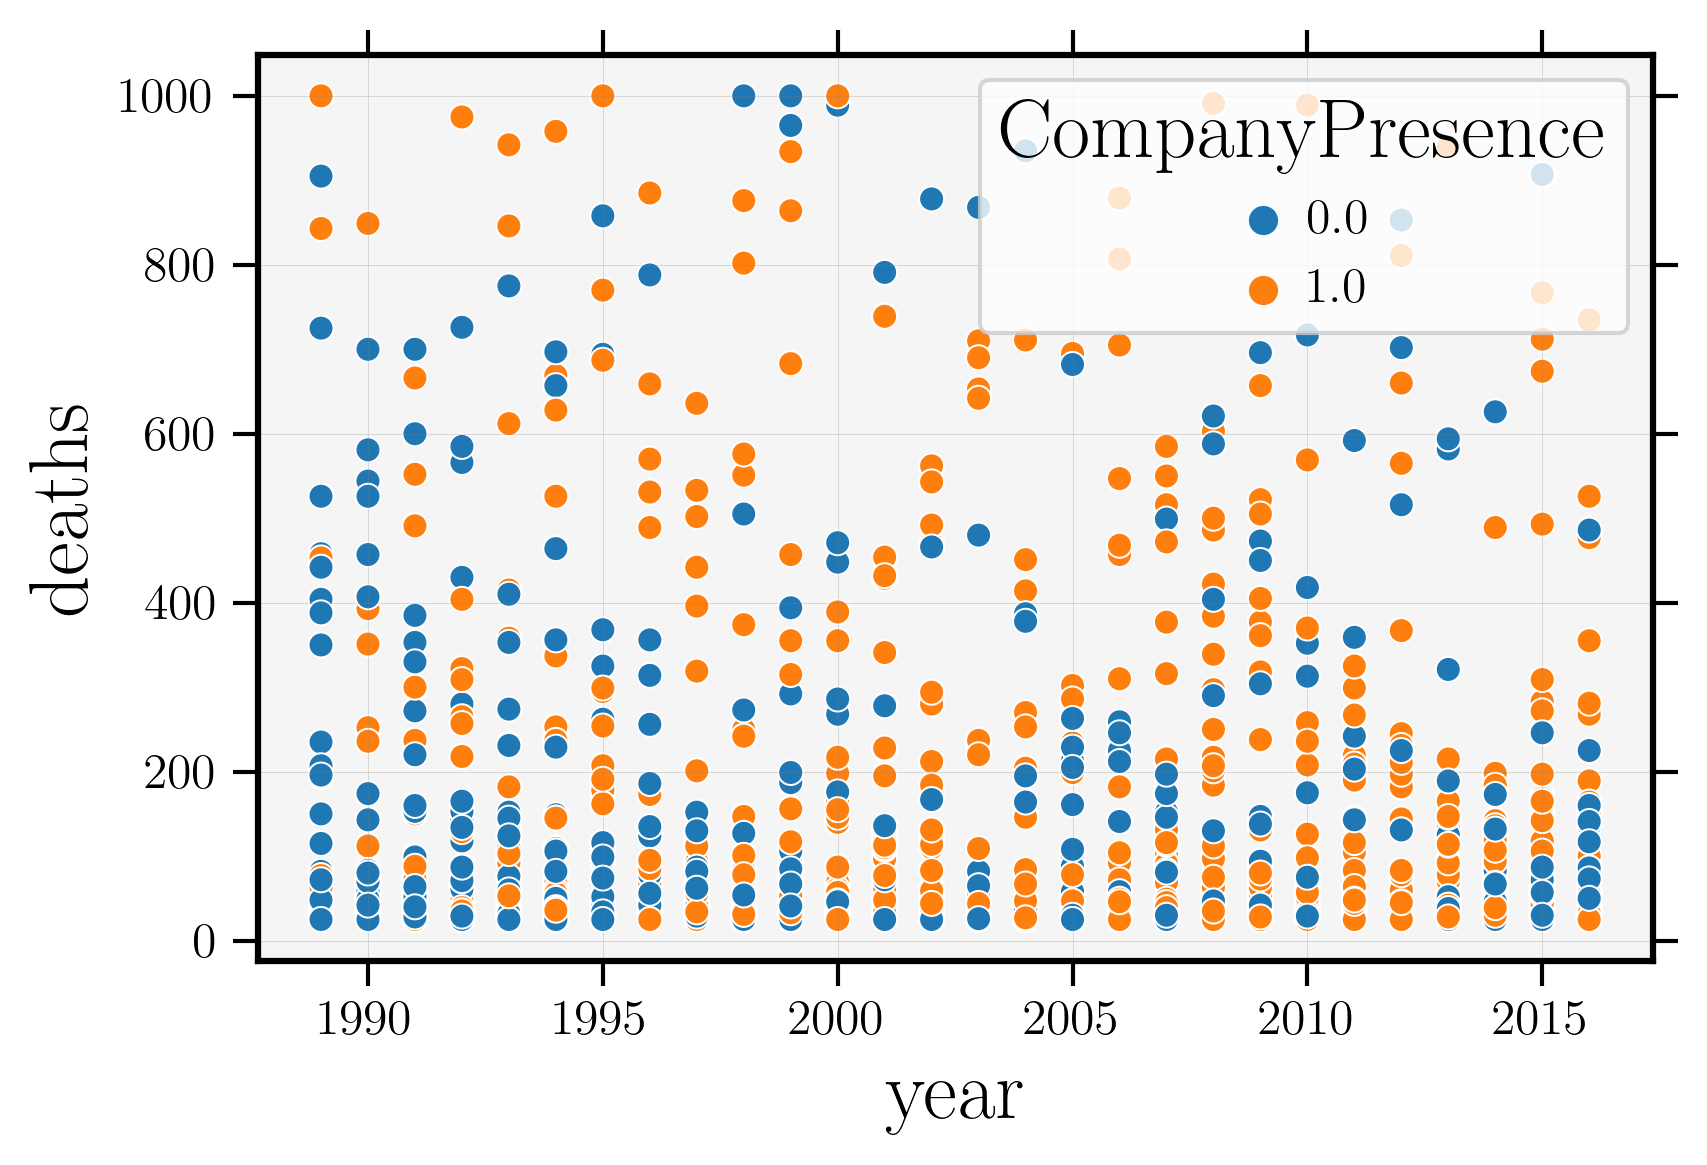

In [119]:
sns.scatterplot(x="year", y="deaths",
                hue="CompanyPresence",data=low_intensity)

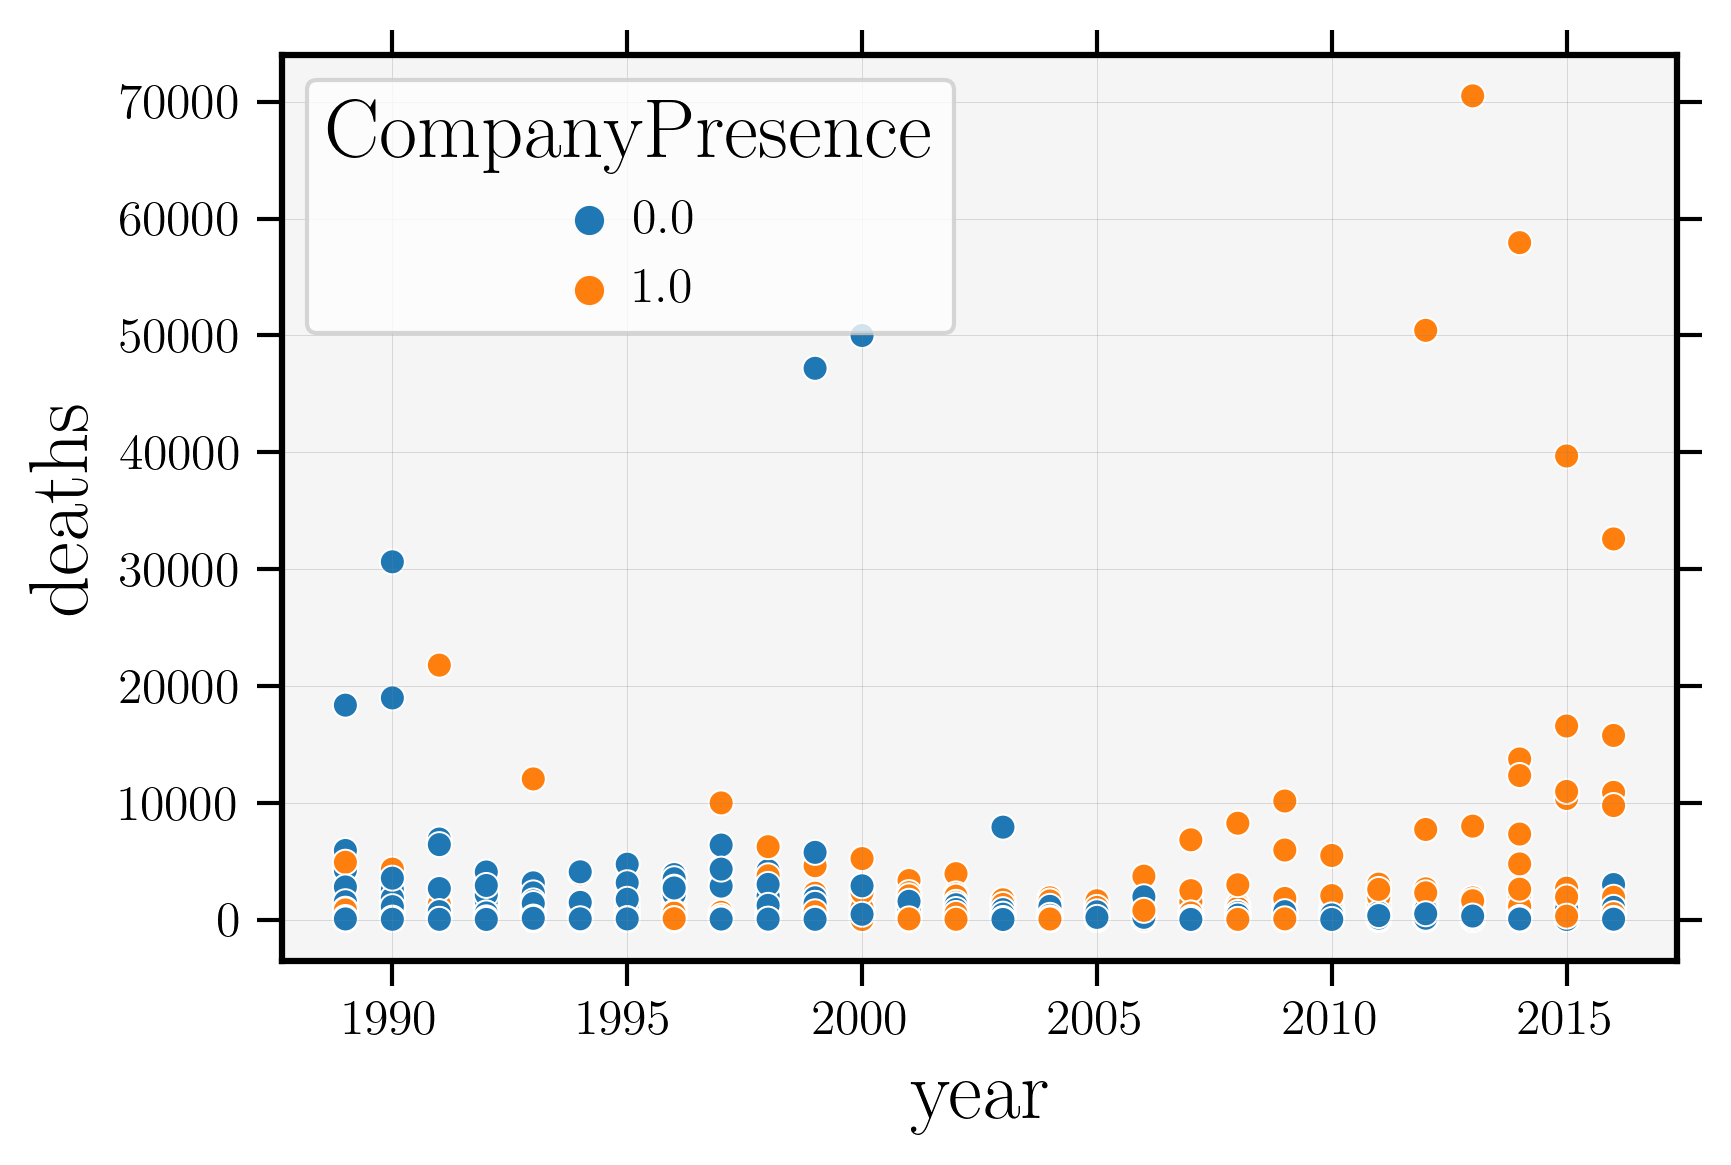

In [130]:
sns.scatterplot(x="year", y="deaths",
                hue="CompanyPresence",data=cmad_merged)
plt.savefig('figures/CompanyPresenceOverTime.png')

In [128]:
data = low_intensity
year_dummies = pd.get_dummies(data['year'], prefix='year')
conflict_dummies = pd.get_dummies(data['conflict_id'], prefix='conflict')
data = pd.concat([data, year_dummies, conflict_dummies], axis=1)

y = data['deaths']
X = data[['CompanyPresence'] + list(year_dummies.columns) + list(conflict_dummies.columns)]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     2.391
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           8.68e-17
Time:                        11:53:45   Log-Likelihood:                -6272.9
No. Observations:                 952   AIC:                         1.293e+04
Df Residuals:                     761   BIC:                         1.386e+04
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
CompanyPresence    52.4942     21.933     

## PSED DATA

In [ ]:
df = pd.read_csv('data/PSED 1990-2012 Feb 2019.csv', encoding='latin-1')
df.head()

from ccode_replace_python import replace_ccode_country as rcc
import pycountry

def make_country_code(x):
    return pycountry.countries.lookup(x['Country Code']).name
df['country_name'] = df.apply(make_country_code, axis=1)
df = rcc.ccode_make(df, 'country_name')

df['count'] = 1
psed_year = df.groupby(['ccode', 'Year'])['count'].sum().reset_index()
psed_year['ccode'] = psed_year['ccode'].astype(int)
psed_year['Year'] = psed_year['Year'].astype(int)
psed_year.head()

bd_deaths.gwno_a = bd_deaths.gwno_a.str.replace('900, 200, 2', '900')
bd_deaths.gwno_a = bd_deaths.gwno_a.astype(int)

bd_deaths.year = bd_deaths.year.astype(int)

merged = bd_deaths.merge(psed_year, left_on=['gwno_a', 'year'], right_on=['ccode', 'Year'], how='left')
merged


merged.bd_best = merged.bd_best.astype(int)
merged.fillna(0)[['bd_best', 'count']].plot(kind='scatter', x='bd_best', y='count')

merged.groupby('year')['bd_best'].sum().plot()


merged.sort_values('bd_best', ascending=False).head(10)

In [60]:


url = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.geojson'


def return_gpd_full(url):
    return gpd.read_file(url)

def return_gpd_year(df, year):
    if year > 2019:
        y = 2019
    else:
        y = year
    temp = df.sort_values(['gweyear'], ascending=False)
    temp = temp.loc[(temp['gwsyear'] <= y) & (temp['gweyear'] >= y)]
    return temp.drop_duplicates(subset = ['gwcode',], keep='first')


full_history = gpd.read_file(url)
year_2000 = return_gpd_year(full_history, 2000)


/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

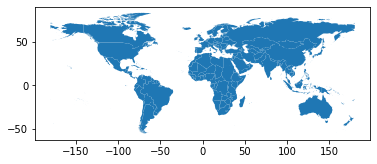

In [59]:
year_2000.plot()

In [95]:
year_2015 = return_gpd_year(full_history, 2015)

In [108]:
year_2015.loc[year_2015.cntry_name == "Syria"]


,cntry_name,area,capname,caplong,caplat,gwcode,gwsdate,gwsyear,gwsmonth,gwsday,gwedate,gweyear,gwemonth,gweday,cap_geom,geometry
499,Syria,186881.0,Damascus,36.3,33.5,652,09.06.1967 23:00:00,1967,6,10,30.12.2019 23:00:00,2019,12,31,SRID=4326;POINT (36.29999923706055 33.5),"POLYGON ((42.35561 37.10693, 42.35707 37.12971..."


In [110]:
cmad_merged.groupby([ 'gwno_a', 'side_a'])[['CompanyPresence', 'ContractCount', 'deaths']].sum().reset_index()

,gwno_a,side_a,CompanyPresence,ContractCount,deaths
0,2,Government of United States of America,0.0,0.0,5435
1,41,Government of Haiti,1.0,2.0,354
2,52,Government of Trinidad and Tobago,0.0,0.0,39
3,70,Government of Mexico,2.0,8.0,182
4,90,Government of Guatemala,5.0,10.0,426
...,...,...,...,...,...
83,820,Government of Malaysia,1.0,1.0,70
84,840,Government of Philippines,41.0,77.0,15168
85,850,Government of Indonesia,3.0,5.0,3585
86,900,"Government of Australia, Government of United ...",0.0,0.0,7927


In [147]:
cmad_merged.gwno_loc = cmad_merged.gwno_loc.replace("625, 626", "625").replace("702, 703", "702").replace('2, 200, 700', '700').replace('630, 666', '630').replace('750, 770', '750').replace('710, 750', '710').replace('800, 811', '800').replace('2, 95', '95').replace('645, 690', '645').replace('', '645').replace('130, 135', '130').replace('471, 475', '471').replace('530, 531', '530').replace('2, 200, 645, 900', '900').replace('522, 531', '522')

cmad_merged.gwno_loc = cmad_merged.gwno_loc.astype(int)
year_2015_merged = year_2015.merge(cmad_merged.groupby([ 'gwno_loc', 'side_a'])[['CompanyPresence', 'ContractCount', 'deaths']].sum().reset_index(), left_on=['gwcode'], right_on=['gwno_loc'], how='left')

In [149]:
year_2015_merged[['CompanyPresence', 'ContractCount', 'deaths']] = year_2015_merged[['CompanyPresence', 'ContractCount', 'deaths']].fillna(0)

/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

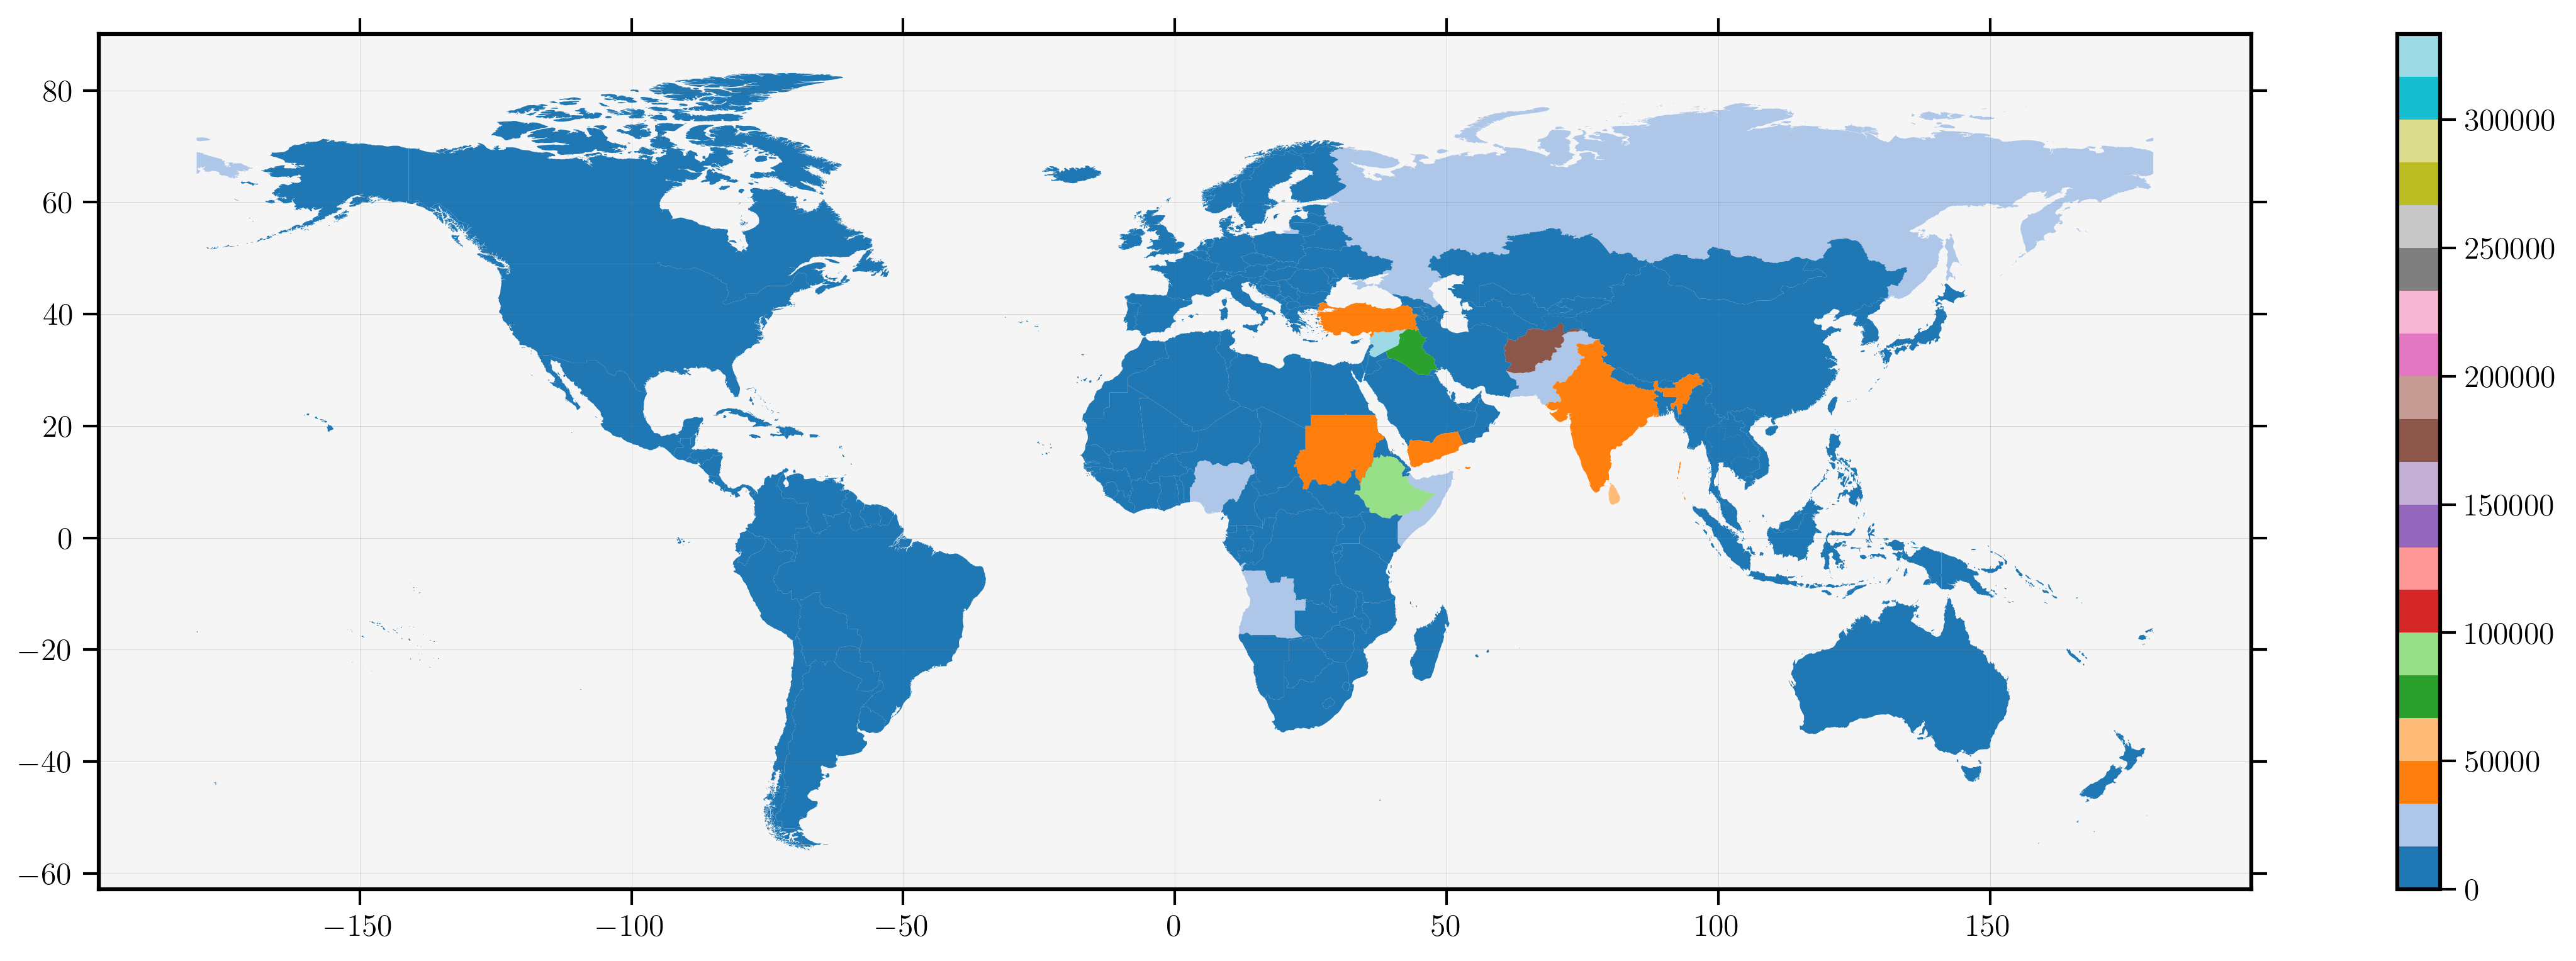

In [150]:
year_2015_merged.plot(column='deaths', cmap='tab20', legend=True, figsize=(20, 6))

In [151]:
bins = [-1, 1, 100, 1000, 10000, float('inf')]

# Use pandas.cut() to bin the column
year_2015_merged['binned_values'] = pd.cut(year_2015_merged['deaths'], bins=bins, labels=['0', '1-100', '100-1000', '1000-1000', '10000+'])


In [152]:
year_2015_merged[['binned_values', 'deaths']]

,binned_values,deaths
0,100-1000,585.0
1,10000+,15168.0
2,100-1000,113.0
3,0,0.0
4,0,0.0
...,...,...
180,0,0.0
181,0,0.0
182,1000-1000,1430.0
183,10000+,333353.0


/opt/anaconda3/envs/pyold/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

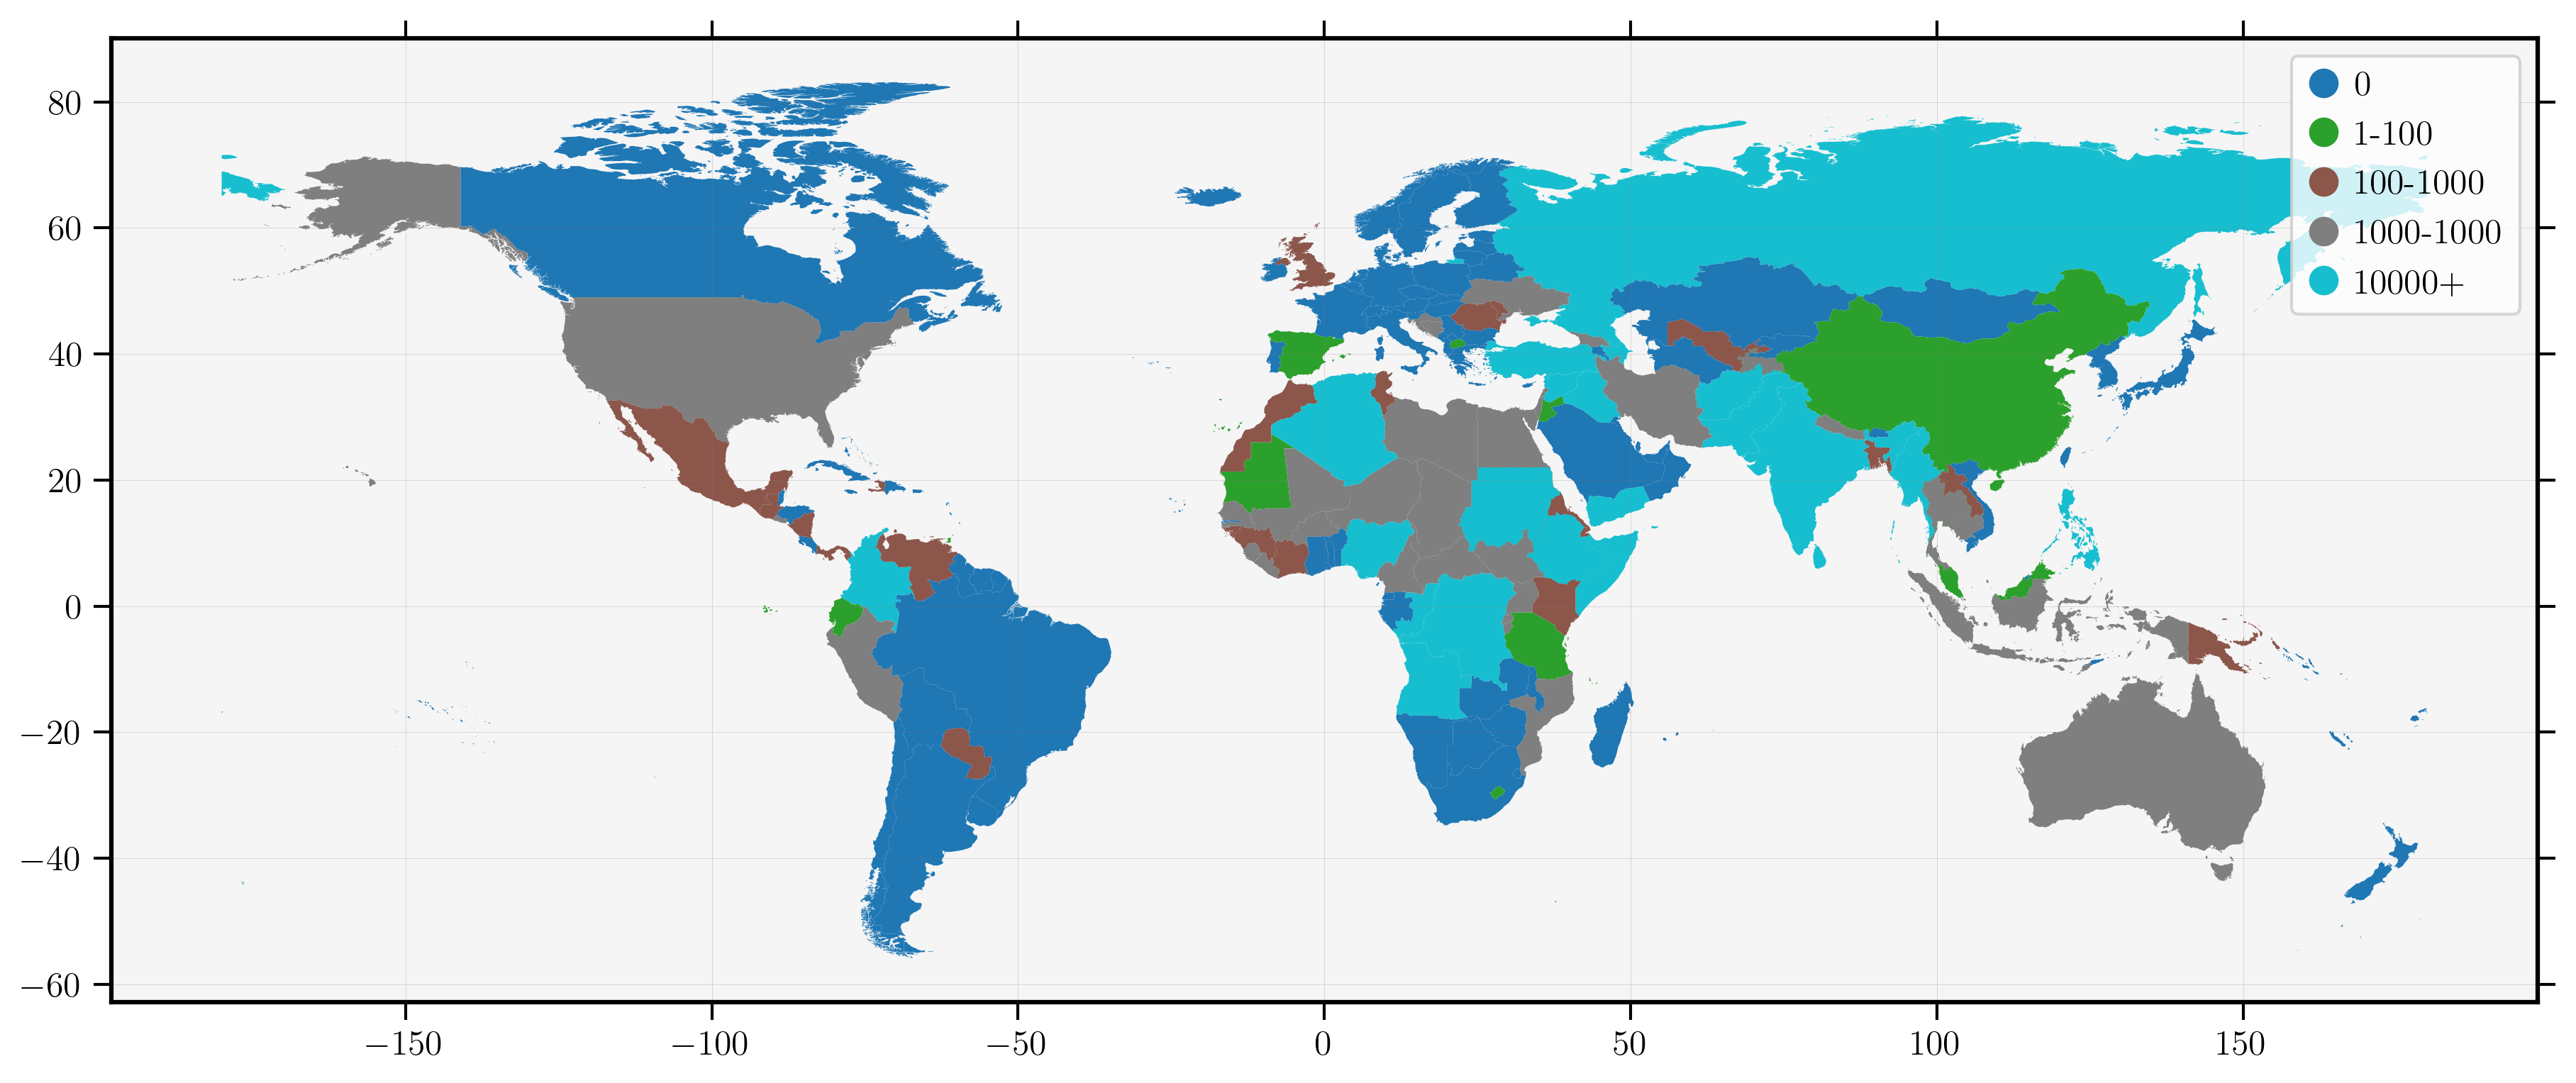

In [154]:
year_2015_merged.plot(column='binned_values', cmap='tab10', legend=True, figsize=(20, 6))

In [159]:
if 'binned_values' in year_2015_merged.columns:
    print('yes')

yes
